<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      2000 non-null   int64  
 1   Product ID               2000 non-null   object 
 2   Type                     2000 non-null   object 
 3   Air temperature [K]      2000 non-null   float64
 4   Process temperature [K]  2000 non-null   float64
 5   Rotational speed [rpm]   2000 non-null   int64  
 6   Torque [Nm]              2000 non-null   float64
 7   Tool wear [min]          2000 non-null   int64  
 8   Machine failure          2000 non-null   int64  
 9   TWF                      2000 non-null   int64  
 10  HDF                      2000 non-null   int64  
 11  PWF                      2000 non-null   int64  
 12  OSF                      2000 non-null   int64  
 13  RNF                      2000 non-null   int64  
dtypes: float64(3), int64(9),

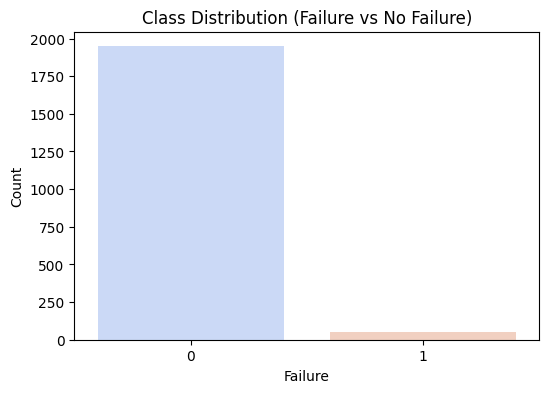

Training Gaussian Process Classifier on SMOTE Data...
Training Gaussian Process Classifier on ADASYN Data...
Training Random Forest on SMOTE Data...
Training Random Forest on ADASYN Data...
Training SVM on SMOTE Data...
Training SVM on ADASYN Data...
Training Gradient Boosting on SMOTE Data...
Training Gradient Boosting on ADASYN Data...

Model Performance Comparison:
        Gaussian Process Classifier  Random Forest     SVM  Gradient Boosting
SMOTE                        0.9675         0.9900  0.9650             0.9800
ADASYN                       0.9600         0.9925  0.9525             0.9825


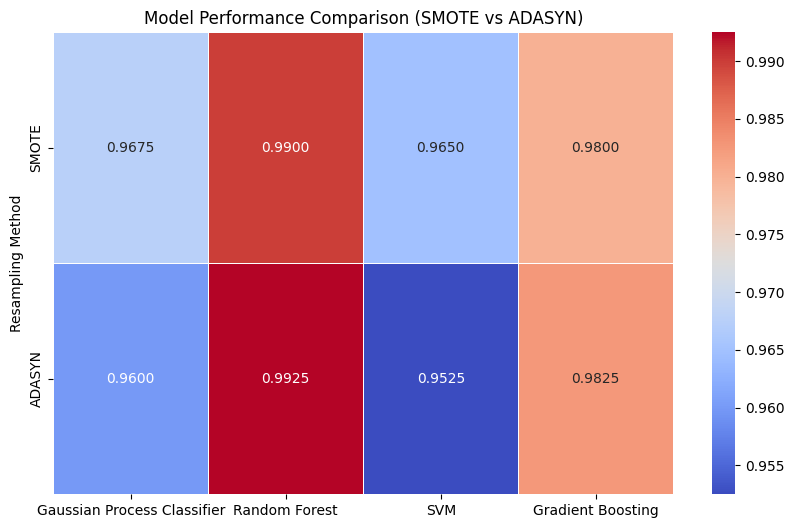

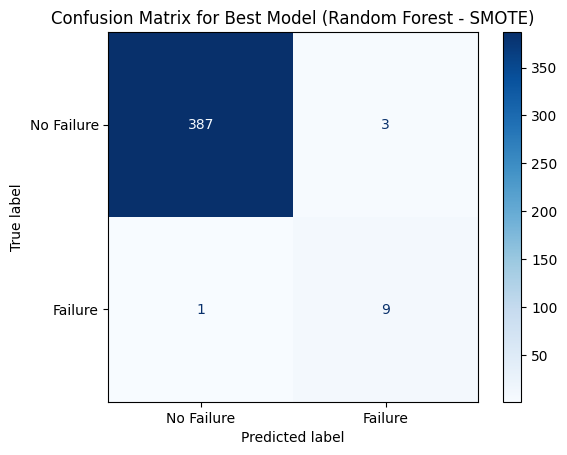

In [ ]:
# Step 1: Importing Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings("ignore")

# Step 2: Load Dataset
df = pd.read_csv("ai4i2020.csv")

# Step 3: Data Exploration
print(df.info())  # Check data types
print(df.describe())  # Summary statistics
print(df.isnull().sum())  # Check for missing values

# Step 4: Handling Class Imbalance Visualization
plt.figure(figsize=(6,4))
sns.countplot(x=df["Machine failure"], palette="coolwarm", alpha=0.7)
plt.title("Class Distribution (Failure vs No Failure)")
plt.xlabel("Failure")
plt.ylabel("Count")
plt.show()

# Step 5: Feature Engineering
df["Failure"] = df["Machine failure"]
df.drop(["UDI", "Product ID", "Machine failure"], axis=1, inplace=True)

# Handle Categorical Data (Fixes the 'could not convert string to float' issue)
if df["Type"].dtype == 'object':
    label_enc = LabelEncoder()
    df["Type"] = label_enc.fit_transform(df["Type"])

# Step 6: Splitting Data
X = df.drop("Failure", axis=1)
y = df["Failure"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Handling Class Imbalance with SMOTE & ADASYN
smote = SMOTE(sampling_strategy=1.0, random_state=42)
adasyn = ADASYN(sampling_strategy=1.0, random_state=42)

X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Step 8: Scaling Features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_train_adasyn = scaler.transform(X_train_adasyn)
X_test = scaler.transform(X_test)

# Step 9: Model Selection with Class Weights
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(kernel=RBF(1.0)),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

# Train and Evaluate Models on SMOTE and ADASYN
results = {"SMOTE": {}, "ADASYN": {}}
for name, model in models.items():
    print(f"Training {name} on SMOTE Data...")
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)
    results["SMOTE"][name] = accuracy_smote

    print(f"Training {name} on ADASYN Data...")
    model.fit(X_train_adasyn, y_train_adasyn)
    y_pred_adasyn = model.predict(X_test)
    accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
    results["ADASYN"][name] = accuracy_adasyn

# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Step 10: Visualizing Model Performance
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.ylabel("Resampling Method")
plt.title("Model Performance Comparison (SMOTE vs ADASYN)")
plt.show()

# Step 11: Confusion Matrix for Best Model (Random Forest with SMOTE)
best_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Failure", "Failure"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Best Model (Random Forest - SMOTE)")
plt.show()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      2000 non-null   int64  
 1   Product ID               2000 non-null   object 
 2   Type                     2000 non-null   object 
 3   Air temperature [K]      2000 non-null   float64
 4   Process temperature [K]  2000 non-null   float64
 5   Rotational speed [rpm]   2000 non-null   int64  
 6   Torque [Nm]              2000 non-null   float64
 7   Tool wear [min]          2000 non-null   int64  
 8   Machine failure          2000 non-null   int64  
 9   TWF                      2000 non-null   int64  
 10  HDF                      2000 non-null   int64  
 11  PWF                      2000 non-null   int64  
 12  OSF                      2000 non-null   int64  
 13  RNF                      2000 non-null   int64  
dtypes: float64(3), int64(9),

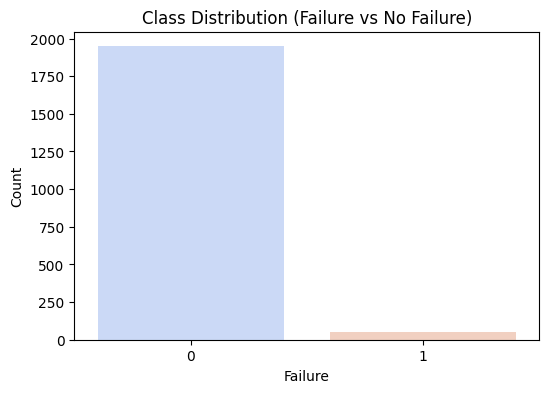

Training Gaussian Process Classifier on SMOTE Data...
Training Gaussian Process Classifier on ADASYN Data...
Training Random Forest on SMOTE Data...
Training Random Forest on ADASYN Data...
Training SVM on SMOTE Data...
Training SVM on ADASYN Data...
Training Gradient Boosting on SMOTE Data...
Training Gradient Boosting on ADASYN Data...

Model Performance Comparison:
        Gaussian Process Classifier  Random Forest     SVM  Gradient Boosting
SMOTE                        0.9675         0.9900  0.9650             0.9800
ADASYN                       0.9600         0.9925  0.9525             0.9825


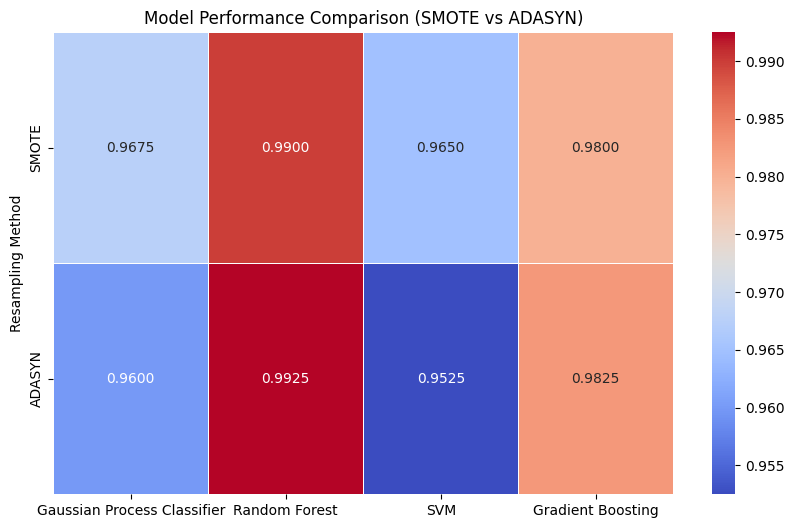

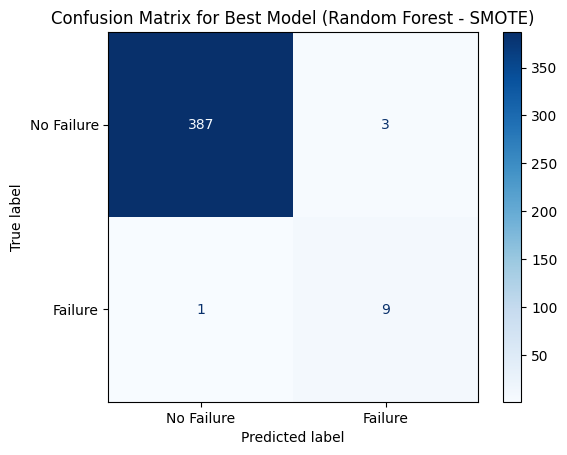


Gaussian Process Regression Performance:
MAE: 0.025
MSE: 0.025
R² Score: -0.025641025641025772
Best Parameters for Random Forest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}


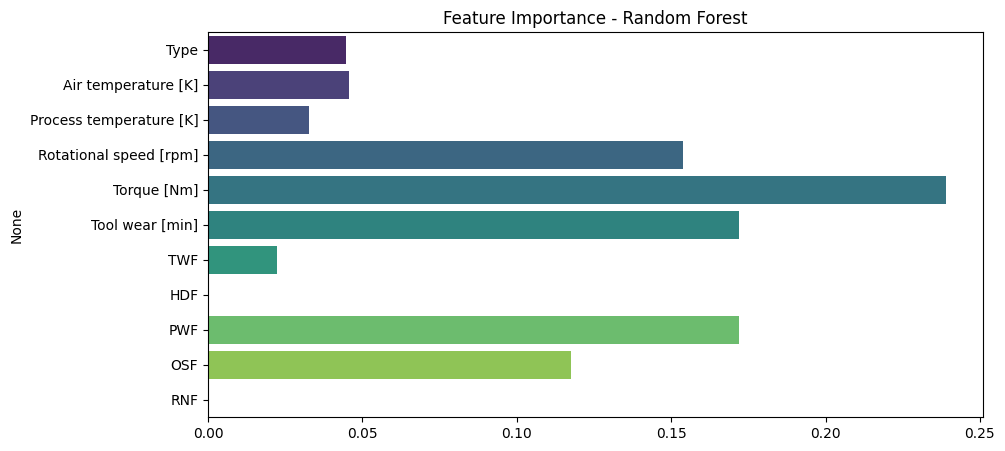

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier, GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from imblearn.over_sampling import SMOTE, ADASYN
import warnings
warnings.filterwarnings("ignore")

# Step 2: Load Dataset
df = pd.read_csv("ai4i2020.csv")

# Step 3: Data Exploration
print(df.info())
print(df.describe())
print(df.isnull().sum())

# Step 4: Handling Class Imbalance Visualization
plt.figure(figsize=(6,4))
sns.countplot(x=df["Machine failure"], palette="coolwarm", alpha=0.7)
plt.title("Class Distribution (Failure vs No Failure)")
plt.xlabel("Failure")
plt.ylabel("Count")
plt.show()

# Step 5: Feature Engineering
df["Failure"] = df["Machine failure"]
df.drop(["UDI", "Product ID", "Machine failure"], axis=1, inplace=True)

# Handle Categorical Data (More Robust Method)
df["Type"] = df["Type"].astype("category").cat.codes

# Step 6: Splitting Data
X = df.drop("Failure", axis=1)
y = df["Failure"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 7: Handling Class Imbalance with SMOTE & ADASYN
smote = SMOTE(sampling_strategy=1.0, random_state=42)
adasyn = ADASYN(sampling_strategy=1.0, random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
X_train_adasyn, y_train_adasyn = adasyn.fit_resample(X_train, y_train)

# Step 8: Scaling Features
scaler = StandardScaler()
X_train_smote = scaler.fit_transform(X_train_smote)
X_train_adasyn = scaler.transform(X_train_adasyn)
X_test = scaler.transform(X_test)

# Step 9: Model Selection with Class Weights
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(kernel=RBF(1.0)),
    "Random Forest": RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42),
    "SVM": SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42),
}

# Train and Evaluate Models on SMOTE and ADASYN
results = {"SMOTE": {}, "ADASYN": {}}
for name, model in models.items():
    print(f"Training {name} on SMOTE Data...")
    model.fit(X_train_smote, y_train_smote)
    y_pred_smote = model.predict(X_test)
    accuracy_smote = accuracy_score(y_test, y_pred_smote)
    results["SMOTE"][name] = accuracy_smote

    print(f"Training {name} on ADASYN Data...")
    model.fit(X_train_adasyn, y_train_adasyn)
    y_pred_adasyn = model.predict(X_test)
    accuracy_adasyn = accuracy_score(y_test, y_pred_adasyn)
    results["ADASYN"][name] = accuracy_adasyn

# Convert Results to DataFrame
results_df = pd.DataFrame(results).T
print("\nModel Performance Comparison:")
print(results_df)

# Step 10: Visualizing Model Performance
plt.figure(figsize=(10, 6))
sns.heatmap(results_df, annot=True, fmt=".4f", cmap="coolwarm", linewidths=0.5)
plt.ylabel("Resampling Method")
plt.title("Model Performance Comparison (SMOTE vs ADASYN)")
plt.show()

# Step 11: Confusion Matrix for Best Model (Random Forest with SMOTE)
best_model = RandomForestClassifier(n_estimators=100, class_weight="balanced", random_state=42)
best_model.fit(X_train_smote, y_train_smote)
y_pred_best = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred_best)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Failure", "Failure"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix for Best Model (Random Forest - SMOTE)")
plt.show()

# Step 12: Gaussian Process Regression (GPR) for Continuous Predictions
gpr = GaussianProcessRegressor(kernel=RBF(1.0))
gpr.fit(X_train_smote, y_train_smote)
y_pred_gpr = gpr.predict(X_test)

# Evaluate GPR Model
print("\nGaussian Process Regression Performance:")
print("MAE:", mean_absolute_error(y_test, y_pred_gpr))
print("MSE:", mean_squared_error(y_test, y_pred_gpr))
print("R² Score:", r2_score(y_test, y_pred_gpr))

# Step 13: Hyperparameter Tuning for Random Forest
param_grid_rf = {'n_estimators': [100, 200], 'max_depth': [10, 20], 'min_samples_split': [2, 5]}
grid_search_rf = GridSearchCV(RandomForestClassifier(class_weight="balanced"), param_grid_rf, cv=3, n_jobs=-1)
grid_search_rf.fit(X_train_smote, y_train_smote)

print("Best Parameters for Random Forest:", grid_search_rf.best_params_)

# Step 14: Feature Importance Visualization
rf_feature_importance = best_model.feature_importances_
plt.figure(figsize=(10, 5))
sns.barplot(x=rf_feature_importance, y=X.columns, palette="viridis")
plt.title("Feature Importance - Random Forest")
plt.show()


In [10]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, ConstantKernel as C
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.model_selection import GridSearchCV

# Define possible kernels
kernel_options = [
    C(1.0) * RBF(length_scale=1.0),
    C(1.0) * Matern(length_scale=1.0, nu=1.5),
    C(1.0) * RationalQuadratic(length_scale=1.0, alpha=1.0)
]

param_grid = {
    "kernel": kernel_options,
    "alpha": [1e-10, 1e-5, 1e-2],  # Noise level in data
}

gpr = GaussianProcessRegressor()
gpr_search = GridSearchCV(gpr, param_grid, scoring="r2", cv=3, n_jobs=-1)

gpr_search.fit(X_train_smote, y_train_smote)  # Training with SMOTE-balanced data

# Best GPR model
best_gpr = gpr_search.best_estimator_
y_pred_gpr = best_gpr.predict(X_test)

# Evaluate GPR performance
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae_gpr = mean_absolute_error(y_test, y_pred_gpr)
mse_gpr = mean_squared_error(y_test, y_pred_gpr)
r2_gpr = r2_score(y_test, y_pred_gpr)

print("Optimized Gaussian Process Regression Performance:")
print(f"Best Kernel: {gpr_search.best_params_['kernel']}")
print(f"Best Alpha: {gpr_search.best_params_['alpha']}")
print(f"MAE: {mae_gpr:.4f}")
print(f"MSE: {mse_gpr:.4f}")
print(f"R² Score: {r2_gpr:.4f}")


Optimized Gaussian Process Regression Performance:
Best Kernel: 1**2 * RationalQuadratic(alpha=1, length_scale=1)
Best Alpha: 0.01
MAE: 0.0440
MSE: 0.0145
R² Score: 0.4038
